<a href="https://colab.research.google.com/github/NeuroCodeInnovations/Estimacion_Peso_Cuyes/blob/main/Yolov8/Segmentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/MyDrive/PDSEI-Segmentacion

/content/drive/MyDrive/PDSEI-Segmentacion


In [ ]:
import os
HOME = os.getcwd()

In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content/drive/MyDrive/PDSEI-Segmentacion
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wconidj7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wconidj7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=e10ebdb45c1fb6e2a842a212ecf13426ee37821e507b0c406e79f3db00d140da
  Stored in directory: /tmp/pip-ephem-wheel-cache-orkgoo4a/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [ ]:
%cd {HOME}
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

/content/drive/MyDrive/PDSEI-Segmentacion
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.2 MB/s eta 0:00:00


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/drive/MyDrive/PDSEI-Segmentacion/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
mask_predictor = SamPredictor(sam)

# Calculo del factor con la mediana estadística

In [ ]:
import os
import cv2
import numpy as np
from scipy.stats import median_abs_deviation
import supervision as sv
import csv

# Definición de los grupos
def generar_grupos():
    grupos = []
    grupos.extend([f"B_CUY_01_{i:03d}" for i in range(1, 119)])
    grupos.extend([f"CUY_01_{i:03d}" for i in range(1, 119)])
    grupos.extend([f"CUY_00_{i:03d}" for i in range(2, 227)])
    return grupos

# Leer los pesos del archivo
def leer_pesos(path_pesos):
    pesos_por_grupo = {}
    with open(path_pesos, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Saltar la cabecera
        for row in reader:
            filename, weight = row
            grupo = "_".join(filename.split("_")[:3])
            pesos_por_grupo[grupo] = float(weight)
    return pesos_por_grupo

# Generar la lista de pesos en el orden de los grupos
def generar_lista_pesos(grupos, pesos_por_grupo):
    lista_pesos = []
    for grupo in grupos:
        grupo_clave = grupo[2:] if grupo.startswith("B_") else grupo
        peso = pesos_por_grupo.get(grupo_clave, 0)
        lista_pesos.append(peso)
    return lista_pesos

# Configuración de rutas
path = '/content/drive/MyDrive/PDSEI/data'
path_annotations = '/content/drive/MyDrive/PDSEI/ImagenesAnotadas'
path_pesos = '/content/drive/MyDrive/PDSEI/data/Pesos.txt'
images_folder = os.path.join(path, "images")

# Generar la lista de grupos y pesos
grupos = generar_grupos()
pesos_por_grupo = leer_pesos(path_pesos)
lista_pesos = generar_lista_pesos(grupos, pesos_por_grupo)

# Crear listas para almacenar resultados
pixeles_prom = []
factores_cuy_promedio = []  # Lista de factores promedio por cuy

# Procesar cada grupo
for grupo, peso in zip(grupos, lista_pesos):
    print(f"\nProcesando grupo: {grupo} (Peso: {peso}g)")

    # Filtrar imágenes del grupo
    imagenes_grupo = [
        img for img in os.listdir(images_folder)
        if img.startswith(grupo) and img.endswith(".jpg")
    ]

    pixeles_por_imagen = []
    factores_individuales = []  # Para almacenar factores de cada imagen de este cuy

    for IMAGE_NAME in imagenes_grupo:
        IMAGE_PATH = os.path.join(images_folder, IMAGE_NAME)
        TXT_PATH = os.path.join(path_annotations, IMAGE_NAME.replace('.jpg', '.txt'))

        # Leer la imagen
        imagen = cv2.imread(IMAGE_PATH)
        if imagen is None:
            print(f"No se pudo leer la imagen: {IMAGE_PATH}")
            continue

        altura, ancho = imagen.shape[:2]
        pixeles_totales = altura * ancho

        # Leer el archivo .txt y realizar predicción
        try:
            with open(TXT_PATH, 'r') as file:
                line = file.readline().strip()
                valores = line.split()
                if len(valores) >= 5:
                    xc, yc, an, al = map(float, valores[1:5])
                    x1 = (xc - an / 2) * ancho
                    y1 = (yc - al / 2) * altura
                    x2 = (xc + an / 2) * ancho
                    y2 = (yc + al / 2) * altura

                    box = np.array([x1, y1, x2, y2])

                    image_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

                    mask_predictor.set_image(image_rgb)

                    masks, scores, logits = mask_predictor.predict(
                        box=box,
                        multimask_output=True
                    )

                    detections = sv.Detections(
                        xyxy=sv.mask_to_xyxy(masks=masks),
                        mask=masks
                    )
                    detections = detections[detections.area == np.max(detections.area)]

                    if detections.area[0] > pixeles_totales * 0.1:
                        print(f"Imagen {IMAGE_NAME} excluida por detección demasiado grande.")
                        continue

                    numero_pixeles_mascara = detections.area[0]
                    pixeles_por_imagen.append(numero_pixeles_mascara)

                    factor_cuy = peso / numero_pixeles_mascara if numero_pixeles_mascara > 0 else 0
                    factores_individuales.append(factor_cuy)

        except FileNotFoundError:
            print(f"Archivo TXT no encontrado para la imagen: {TXT_PATH}")
            continue

    if factores_individuales:
        # Calcular la mediana de los factores individuales
        mediana_factor_cuy = np.median(factores_individuales)
        print(f"Mediana de factores para {grupo}: {mediana_factor_cuy:.2f}")

        # Filtrar valores superiores a 1.2 * mediana
        factores_filtrados = [f for f in factores_individuales if f <= 1.2 * mediana_factor_cuy]

        if factores_filtrados:
            promedio_factor_cuy = sum(factores_filtrados) / len(factores_filtrados)
            factores_cuy_promedio.append(promedio_factor_cuy)
            print(f"Factor promedio filtrado para {grupo}: {promedio_factor_cuy:.2f}")
        else:
            factores_cuy_promedio.append(0)
            print(f"No se calcularon factores válidos para el grupo {grupo} tras el filtrado.")
    else:
        factores_cuy_promedio.append(0)
        print(f"No se calcularon factores para el grupo {grupo}.")

# Imprimir resultados finales
print("\nFactores promedio por cuy:")
print(factores_cuy_promedio)



Procesando grupo: B_CUY_01_001 (Peso: 308.44256g)
Archivo TXT no encontrado para la imagen: /content/drive/MyDrive/PDSEI/ImagenesAnotadas/B_CUY_01_001_14 (1).txt
Archivo TXT no encontrado para la imagen: /content/drive/MyDrive/PDSEI/ImagenesAnotadas/B_CUY_01_001_12 (1).txt
Archivo TXT no encontrado para la imagen: /content/drive/MyDrive/PDSEI/ImagenesAnotadas/B_CUY_01_001_13 (1).txt
Archivo TXT no encontrado para la imagen: /content/drive/MyDrive/PDSEI/ImagenesAnotadas/B_CUY_01_001_11 (1).txt
Archivo TXT no encontrado para la imagen: /content/drive/MyDrive/PDSEI/ImagenesAnotadas/B_CUY_01_001_09 (1).txt
Archivo TXT no encontrado para la imagen: /content/drive/MyDrive/PDSEI/ImagenesAnotadas/B_CUY_01_001_10 (1).txt
Archivo TXT no encontrado para la imagen: /content/drive/MyDrive/PDSEI/ImagenesAnotadas/B_CUY_01_001_15 (1).txt
Archivo TXT no encontrado para la imagen: /content/drive/MyDrive/PDSEI/ImagenesAnotadas/B_CUY_01_001_08 (1).txt
Archivo TXT no encontrado para la imagen: /content/dr

In [ ]:
factores_cuy_promedio = [0.2224565905803666, 0.2781510790058912, 0.3152436262610019, 0.29759816474630146, 0.24922368296381586, 0.25561165439269407, 0.2924045919104414, 0.24849030185522258, 0.20281944181961165, 0.2858223369461197, 0.23866858030857996, 0.22161394151634778, 0.19817095169660298, 0, 0.2875280866422125, 0.30006206796563856, 0, 0.4027383351623902, 0.27541520855734636, 0, 0.27463547498049895, 0.2849533757439077, 0.28698214285130924, 0, 0.3480864397121311, 0, 0, 0.3684334921244859, 0, 0.32450210151181075, 0.30476263874863935, 0.30274551148508966, 0.2778629709341964, 0.2896138839574975, 0, 0.3144798888860474, 0.2899034458026406, 0.19325684323779072, 0.17932815092670382, 0.24526448971981893, 0, 0.17653461706668735, 0, 0.43415862894635837, 0, 0.26188472079623104, 0.2980782437550897, 0.26214337190746656, 0, 0.3044863984286417, 0.3248150524090265, 0.29892529385226596, 0.32379458663813115, 0.29486039200397507, 0.3455865431333156, 0.37937270243147664, 0.3082144555028913, 0.31997156649478625, 0.3032407498550265, 0.21720543000623985, 0.1911303198797084, 0.23107302835455565, 0.23002139374860853, 0.19259027630295308, 0, 0, 0.2415594313967847, 0.18456310276566945, 0.265910097270867, 0.21898722873651125, 0, 0.2233653861985937, 0.2616783304388957, 0, 0.20933112337687856, 0, 0.34059192274783967, 0.3893401262008214, 0.3811011246150711, 0.3598426287892024, 0.16968486236346092, 0, 0, 0.22684139161001848, 0.1884918523422418, 0, 0.16252456633088663, 0.1591147298183645, 0.20618786214061416, 0.3657916994149242, 0.39473348574941336, 0, 0.3824977740004629, 0.37526566624645447, 0.42061337348249556, 0.3147185683952597, 0.23340216619853962, 0.20797574301769742, 0.22199165163563414, 0.21350066048328017, 0, 0, 0.27622671431200485, 0.22083891008067885, 0.24228246736260023, 0, 0.30165351985654704, 0.28761119934277224, 0.37754682710890625, 0.38296989303604306, 0.3359428327999615, 0.320481523847553, 0, 0.3045097062663895, 0.3909045085702164, 0.3056778288039846, 0.3671647293667334, 0.26293758775415477, 0.21301944690505673, 0.26120153899374854, 0.3220474690283873, 0.3050782991939921, 0.27824744994657097, 0.29630832980815325, 0.2935370305947837, 0.25682350197136894, 0.21830914729512893, 0.2796676534410427, 0.25464443420145294, 0.23698092598668113, 0.2282204907721506, 0, 0.33926970441510323, 0.32991361103263356, 0, 0.3991255348494447, 0.3193627004961858, 0, 0.3281555149717394, 0.3144872183458922, 0.2823659419924575, 0, 0.3552328262174992, 0, 0, 0.3493331144594226, 0, 0.3666944242837128, 0.3298849781935394, 0.30854149033315004, 0.30628190054580906, 0.3033582567256763, 0, 0.30835669293540696, 0.26522269765228773, 0.20549560310371026, 0.1881091621308217, 0.24467975833953784, 0, 0.1673962439262892, 0, 0.41808305344617647, 0, 0.2682748764318535, 0.29787966171684827, 0.27742210946518, 0, 0.307233730287369, 0.35284255154871264, 0.3217679660244376, 0.3184424955222361, 0.3321910134803824, 0.3727254525952751, 0.42160201766170174, 0.33045635874535745, 0.31404889803020775, 0.2980954523636443, 0.3000985023987739, 0.22496786859960863, 0.2992492942224835, 0.2487579368596541, 0.18809247260409848, 0, 0, 0.27112173923418786, 0.20829433069132214, 0.2690174910597094, 0.25288590399891825, 0, 0.2625286778523648, 0.23563081305002406, 0, 0.2514331991464402, 0, 0.4374279263871287, 0.4119379159712741, 0.392271978371888, 0.39517294769654715, 0.2090555137722163, 0, 0, 0.20954886662833352, 0.16391007764280557, 0.1721845382876934, 0.1712452164862738, 0.21026045360218398, 0.20001291196842938, 0.4075886536148493, 0.4318191753999327, 0.4333536242342671, 0, 0.39189069958435235, 0.43956362076304994, 0.30315369883289695, 0.26784998821360134, 0.21586662310094892, 0.20457763419030903, 0.2387517632615227, 0, 0, 0.28829027705377314, 0.26925618479833413, 0.27990944463211154, 0, 0.320854742761937, 0.31828796786109176, 0.3738858473999785, 0.40563392394891407, 0.349680060581646, 0.3028727227509284, 0, 0.3573259264720787, 0.39855786251924397, 0.3221600635259397, 0.3633507201452521, 0.2649198492463218, 0.33252062006965044, 0.46052241202811695, 0.2872252302132343, 0.3202087520011818, 0.27383991210457753, 0, 0.31569061732983755, 0.28966074772032513, 0.2330379526668426, 0.23281729797738787, 0, 0.2801651598381404, 0.316274250878754, 0.44466291136291913, 0.3281152742467663, 0.36966963182858803, 0.491988420037631, 0.47411758554252775, 0.41276781810231744, 0.3465088278846431, 0.4520856373010047, 0, 0.4337834188844316, 0, 0.3514664609009077, 0.3459885386819484, 0.3014815362893785, 0, 0, 0.5577632056910791, 0, 0.5173475625513502, 0.6201130433940771, 0.44319013554656034, 0, 0, 0, 0.4908172983841041, 0.6373563815303632, 0.7025547351563018, 0.6140901001099116, 0.8710962422453927, 0.7134957090490355, 0.815424373906027, 0.8625876691969548, 0.7289414963474619, 0, 0.8628111209370766, 0, 0, 0.6721633158047243, 0.6483022835642593, 0.7987762602555709, 0, 0.5682630911427078, 0.7349353527770681, 0, 0.7490727911088262, 0.8193886521600863, 0.6640592734083803, 0.5905208754543708, 0.7041708404093829, 0.5608513008762042, 0.555541574722744, 0.6374584446628777, 0.49167438309262473, 0.6105377360447413, 0.7510311633062808, 0.7501100176827943, 0, 0.7699744500124268, 0.7224463438521724, 0, 0.8341074544924555, 0, 0, 0.7869660114984005, 0.6178111250132885, 0.7484898836332586, 0, 0, 0.6884149737544281, 0.6958681998452404, 0.5975466849278789, 0, 0, 0.5685401313938881, 0.6022555020477555, 0, 0, 0.5562336138486516, 0.6815409159159159, 0.6049482266331884, 0.6166018897390051, 0.6241360136895413, 0.399181373609975, 0.6580121529237106, 0.5567955791276227, 0.5742512584667404, 0.48896984733967697, 0.44948718554974715, 0.40250003836713905, 0.46676463011221686, 0.569168969011286, 0.48065955101754054, 0.5326528038131636, 0.5933490650143826, 0.5320586464660626, 0, 0.5348664965377552, 0.5105674667234931, 0.5169816470152933, 0.49443550249466667, 0.5636096806362157, 0, 0.6184822101071795, 0.7143587875050801, 0.5954261047296661, 0.6540188596477974, 0, 0.49502795334368643, 0.553172003196763, 0.7845331290229862, 0, 0.4028985507246377, 0.7867507780868438, 0, 0, 0.7271271849992473, 0, 0.5633928571428571, 0.4969733376402889, 0.6740424466254735, 0.33840807215267077, 0.5442639201854264, 0.39214097478770515, 0.36198266244300364, 0, 0.464017238873178, 0.32330200209940513, 0.4022887323943662, 0.33164542515533846, 0.3662671601656201, 0, 0.31268205753888406, 0.35196345403486307, 0.3232833230224798, 0.36842067875960727, 0.45363870393090466, 0, 0.5041862198977338, 0.5237603932503225, 0.4488182580711004, 0, 0.46767831536461413, 0.5587161055203437, 0.5172782776754647, 0, 0.5381558028616852, 0.40016570008285, 0.713641637433796, 0.42909280500521374, 0.7390381895332391, 0.6826473686060017, 0.6050299251815823, 0, 0, 0.6523382882212159, 0, 0, 0.6209828486973259, 0.6109771201355844, 0.8980030000707304, 0.6401930200639347, 0.7496279631291065, 0, 0.6120218579234973, 0.5397688907414483, 0, 0.5994070843293147, 0.6989357954959808, 0.40095076119285666, 0.39587862496357856, 0, 0, 0.43963992757368026, 0, 0.6257144607199734, 0, 0.6869458348691494, 0.649850286098118, 0.4670093382466293, 0.404979217406643, 0.38564086989010726, 0.6845086224586068, 0.4752176065441731, 0.5243638390464553, 0.627729588150545, 0.6049612717245375, 0.7986124988343125, 0, 0.7766688876146042, 0.6141963957337256, 0.6786036873704904, 0.5985915492957746, 0.6328618144209317, 0, 0.6191716216135554, 0, 0.6060144942961142, 0, 0, 0.5848374977811869, 0.5743922772721527, 0.6755674232309746, 0, 0.6164430216349513, 0.6010816359551961, 0.621598115771904, 0.5896150128891092, 0.652469337223231, 0.6430851063829788, 0.5895455704655143, 0.5649304893969742, 0.542148580740995]

In [ ]:
from scipy.stats import median_abs_deviation

# Eliminar valores 0 de la lista de factores promedio
factores_cuy_promedio = [x for x in factores_cuy_promedio if x > 0]

if factores_cuy_promedio:
    mediana = np.median(factores_cuy_promedio)
    umbral = mediana * 1.2

    factores_filtrados = [x for x in factores_cuy_promedio if x <= umbral]

    mediana_filtrada = np.median(factores_filtrados)
    promedio_final = sum(factores_filtrados) / len(factores_filtrados) if factores_filtrados else 0
else:
    mediana = 0
    umbral = 0
    factores_filtrados = []
    mediana_filtrada = 0
    promedio_final = 0

# Imprimir resultados
print("Mediana estadística:", mediana)
print("Umbral:", umbral)
print("Lista filtrada:", factores_filtrados)
print("Mediana filtrada:", mediana_filtrada)
print("Promedio final:", promedio_final)



Mediana estadística: 0.3666944242837128
Umbral: 0.44003330914045535
Lista filtrada: [0.2224565905803666, 0.2781510790058912, 0.3152436262610019, 0.29759816474630146, 0.24922368296381586, 0.25561165439269407, 0.2924045919104414, 0.24849030185522258, 0.20281944181961165, 0.2858223369461197, 0.23866858030857996, 0.22161394151634778, 0.19817095169660298, 0.2875280866422125, 0.30006206796563856, 0.4027383351623902, 0.27541520855734636, 0.27463547498049895, 0.2849533757439077, 0.28698214285130924, 0.3480864397121311, 0.3684334921244859, 0.32450210151181075, 0.30476263874863935, 0.30274551148508966, 0.2778629709341964, 0.2896138839574975, 0.3144798888860474, 0.2899034458026406, 0.19325684323779072, 0.17932815092670382, 0.24526448971981893, 0.17653461706668735, 0.43415862894635837, 0.26188472079623104, 0.2980782437550897, 0.26214337190746656, 0.3044863984286417, 0.3248150524090265, 0.29892529385226596, 0.32379458663813115, 0.29486039200397507, 0.3455865431333156, 0.37937270243147664, 0.3082144

# Testeo

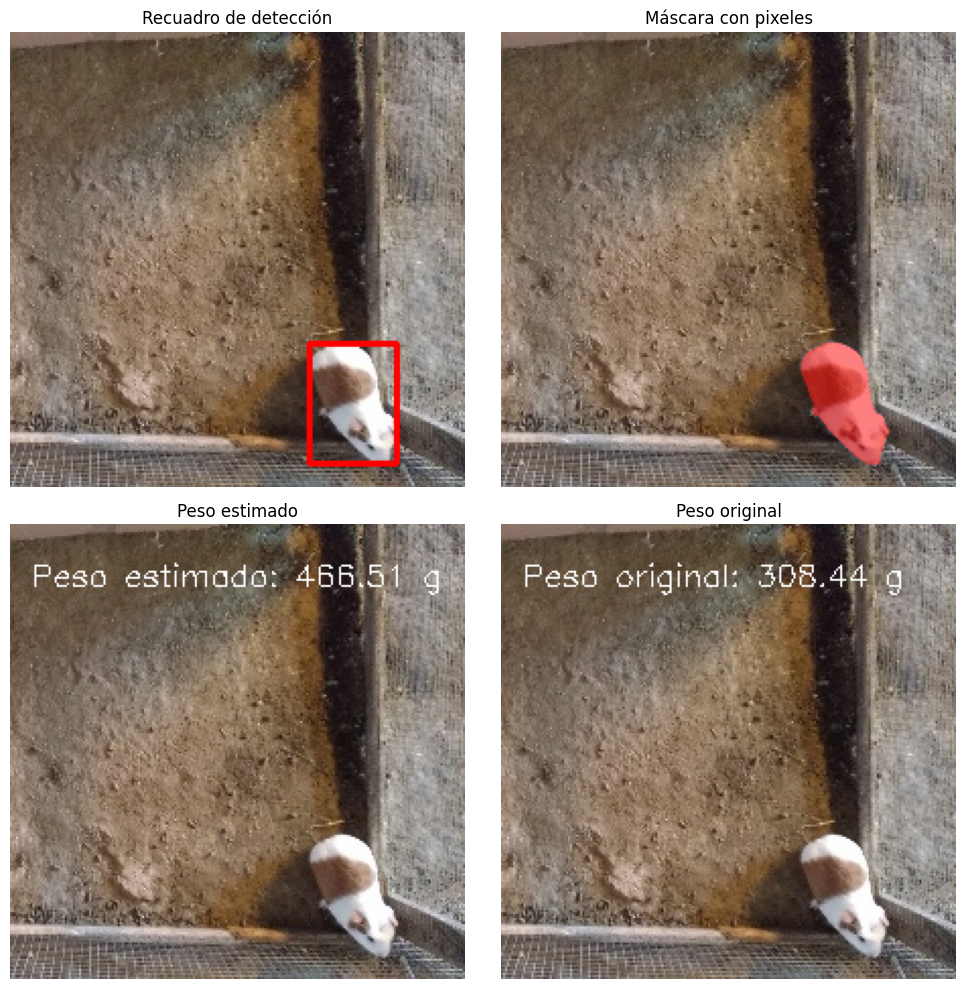

In [ ]:
import os
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

# Configuración inicial
IMAGE_NAME = "B_CUY_01_005_01.jpg"
path = '/content/drive/MyDrive/PDSEI/data'
path_annotations = '/content/drive/MyDrive/PDSEI/ImagenesAnotadas'
path_pesos = '/content/drive/MyDrive/PDSEI/data/Pesos.txt'

IMAGE_PATH = os.path.join(path, "images", IMAGE_NAME)
TXT_PATH = os.path.join(path_annotations, IMAGE_NAME.replace('.jpg', '.txt'))

factor_peso_pixeles = 0.30078200402462574

# Leer el peso del cuy desde el archivo Pesos.txt
def obtener_peso_original(image_name, path_pesos):
    grupo = "_".join(image_name.split("_")[:3])  # Extraer el grupo del nombre
    with open(path_pesos, 'r') as file:
        for line in file.readlines():
            if line.startswith(grupo):
                _, weight = line.strip().split(',')
                return float(weight)  # Devolver el peso en gramos
    return None  # Retornar None si no se encuentra el peso

# Leer la imagen
image_bgr = cv2.imread(IMAGE_PATH)
if image_bgr is None:
    raise FileNotFoundError(f"No se encontró la imagen en la ruta: {IMAGE_PATH}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Leer el archivo .txt
with open(TXT_PATH, 'r') as file:
    line = file.readline().strip()
    valores = line.split()
    if len(valores) >= 5:
        xc, yc, an, al = map(float, valores[1:5])
        altura, ancho = image_bgr.shape[:2]
        x1 = (xc - an / 2) * ancho
        y1 = (yc - al / 2) * altura
        x2 = (xc + an / 2) * ancho
        y2 = (yc + al / 2) * altura
        box = np.array([x1, y1, x2, y2])

# Configurar predictor y realizar predicción
mask_predictor.set_image(image_rgb)
masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

# Crear anotadores y detecciones
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]  # Máscara más grande

# Calcular número de píxeles del cuy
pixeles_cuy = np.sum(detections.mask[0])  # Máscara binaria: suma de píxeles activados

# Calcular peso estimado
peso_estimado = pixeles_cuy * factor_peso_pixeles

# Obtener el peso original del cuy
peso_original = obtener_peso_original(IMAGE_NAME, path_pesos)

# Generar las imágenes anotadas
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)

mask_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
cv2.putText(mask_image, f"Pixeles: {pixeles_cuy}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

peso_estimado_image = image_bgr.copy()
cv2.putText(peso_estimado_image, f"Peso estimado: {peso_estimado:.2f} g", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

peso_original_image = image_bgr.copy()
if peso_original is not None:
    cv2.putText(peso_original_image, f"Peso original: {peso_original:.2f} g", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
else:
    cv2.putText(peso_original_image, "Peso original no encontrado", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Mostrar las imágenes en una cuadrícula 2x2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

titles = ["Recuadro de detección", "Máscara con pixeles", "Peso estimado", "Peso original"]
images = [source_image, mask_image, peso_estimado_image, peso_original_image]

for ax, title, img in zip(axes, titles, images):
    ax.set_title(title)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis("off")

plt.tight_layout()
plt.show()


# Calculo del RMSE

In [ ]:
import os
import numpy as np
import cv2

def calcular_rmse_y_generar_archivo(factor_final, imagenes_dir, txt_dir, pesos_path, output_path):
    resultados = []

    # Leer el archivo de pesos
    try:
        with open(pesos_path, 'r') as f:
            pesos_data = {}
            for line in f:
                try:
                    nombre, peso = line.strip().split(',')
                    pesos_data[nombre] = float(peso)
                except ValueError:
                    print(f"Línea inválida en archivo de pesos: {line.strip()}")
    except Exception as e:
        print(f"Error al leer el archivo de pesos: {e}")
        return

    for archivo in os.listdir(imagenes_dir):
        if archivo.endswith('.jpg'):
            imagen_path = os.path.join(imagenes_dir, archivo)
            nombre_cuy = os.path.splitext(archivo)[0]
            txt_path = os.path.join(txt_dir, f"{nombre_cuy}.txt")

            if not os.path.exists(txt_path):
                continue

            # Leer la imagen
            imagen = cv2.imread(imagen_path)
            if imagen is None:
                print(f"No se pudo cargar la imagen: {imagen_path}")
                continue

            alto_img, ancho_img, _ = imagen.shape

            # Leer el peso real del cuy
            peso_cuy = pesos_data.get(f"{nombre_cuy}.jpg")
            if peso_cuy is None:
                print(f"No se encontró el peso para el cuy: {nombre_cuy}")
                continue

            # Leer las coordenadas del archivo de texto
            try:
                with open(txt_path, "r") as f:
                    linea = f.readline().strip().split()
                    _, x_centro_norm, y_centro_norm, ancho_norm, alto_norm = map(float, linea)

                    # Convertir coordenadas normalizadas a píxeles
                    ancho = int(ancho_norm * ancho_img)
                    alto = int(alto_norm * alto_img)

                    # Calcular el número de píxeles del cuadro delimitador
                    num_pixeles = ancho * alto

                    if num_pixeles == 0 or num_pixeles > 10000:
                        continue

                    # Calcular el peso estimado
                    peso_estimado = num_pixeles * factor_final

                    # Calcular el error cuadrático
                    error_cuadratico = (peso_estimado - peso_cuy) ** 2

                    resultados.append({
                        "nombre": nombre_cuy,
                        "peso_real": peso_cuy,
                        "peso_estimado": peso_estimado,
                        "error_cuadratico": error_cuadratico
                    })

            except Exception as e:
                print(f"Error al leer el archivo de coordenadas {txt_path}: {e}")
                continue

    # Calcular el RMSE
    errores_cuadraticos = [r["error_cuadratico"] for r in resultados]
    rmse = np.sqrt(np.mean(errores_cuadraticos)) if errores_cuadraticos else 0

    # Guardar resultados en un archivo
    with open(output_path, 'w') as f:
        f.write("Nombre de la imagen,Peso real (g),Peso estimado (g),RMSE (g)\n")
        for r in resultados:
            f.write(f"{r['nombre']},{r['peso_real']},{r['peso_estimado']},{np.sqrt(r['error_cuadratico'])}\n")

    # Ordenar resultados por RMSE
    resultados.sort(key=lambda x: np.sqrt(x["error_cuadratico"]))

    # Obtener los análisis solicitados
    top_5_bajos = resultados[:5]
    top_5_altos = resultados[-5:]
    mayores_a_200 = sum(1 for r in resultados if np.sqrt(r["error_cuadratico"]) > 200)
    menores_a_50 = sum(1 for r in resultados if np.sqrt(r["error_cuadratico"]) < 50)

    total = len(resultados)
    porcentaje_mayores_a_200 = (mayores_a_200 / total) * 100 if total > 0 else 0
    porcentaje_menores_a_50 = (menores_a_50 / total) * 100 if total > 0 else 0

    print(f"RMSE total: {rmse:.2f} g")
    print("Top 5 RMSE más bajos:")
    for r in top_5_bajos:
        print(f"{r['nombre']}: {np.sqrt(r['error_cuadratico']):.2f} g")

    print("\nTop 5 RMSE más altos:")
    for r in top_5_altos:
        print(f"{r['nombre']}: {np.sqrt(r['error_cuadratico']):.2f} g")

    print(f"\nPorcentaje de RMSE > 200 g: {porcentaje_mayores_a_200:.2f}%")
    print(f"Porcentaje de RMSE < 50 g: {porcentaje_menores_a_50:.2f}%")

# Configurar las rutas
directorio_imagenes = '/content/drive/MyDrive/PDSEI/Imagenes_Test_Anotadas'
directorio_txt = '/content/drive/MyDrive/PDSEI/Imagenes_Test_Anotadas'
pesos_path = '/content/drive/MyDrive/PDSEI/data/Pesos.txt'
output_path = '/content/drive/MyDrive/PDSEI/resultados.txt'

# Factor final
definir_factor_final = 0.30078200402462574

# Llamar a la función
calcular_rmse_y_generar_archivo(definir_factor_final, directorio_imagenes, directorio_txt, pesos_path, output_path)


Línea inválida en archivo de pesos: filename,weight
RMSE total: 450.09 g
Top 5 RMSE más bajos:
CUY_00_186_02: 10.03 g
CUY_01_043_12: 12.19 g
CUY_01_043_11: 14.00 g
CUY_00_055_08: 15.00 g
CUY_00_091_02: 19.87 g

Top 5 RMSE más altos:
B_CUY_01_045_11: 1036.32 g
B_CUY_01_026_11: 1096.94 g
CUY_01_024_06: 1112.99 g
CUY_00_007_04: 1183.27 g
B_CUY_01_065_10: 1226.91 g

Porcentaje de RMSE > 200 g: 82.03%
Porcentaje de RMSE < 50 g: 3.12%


# Comprobación

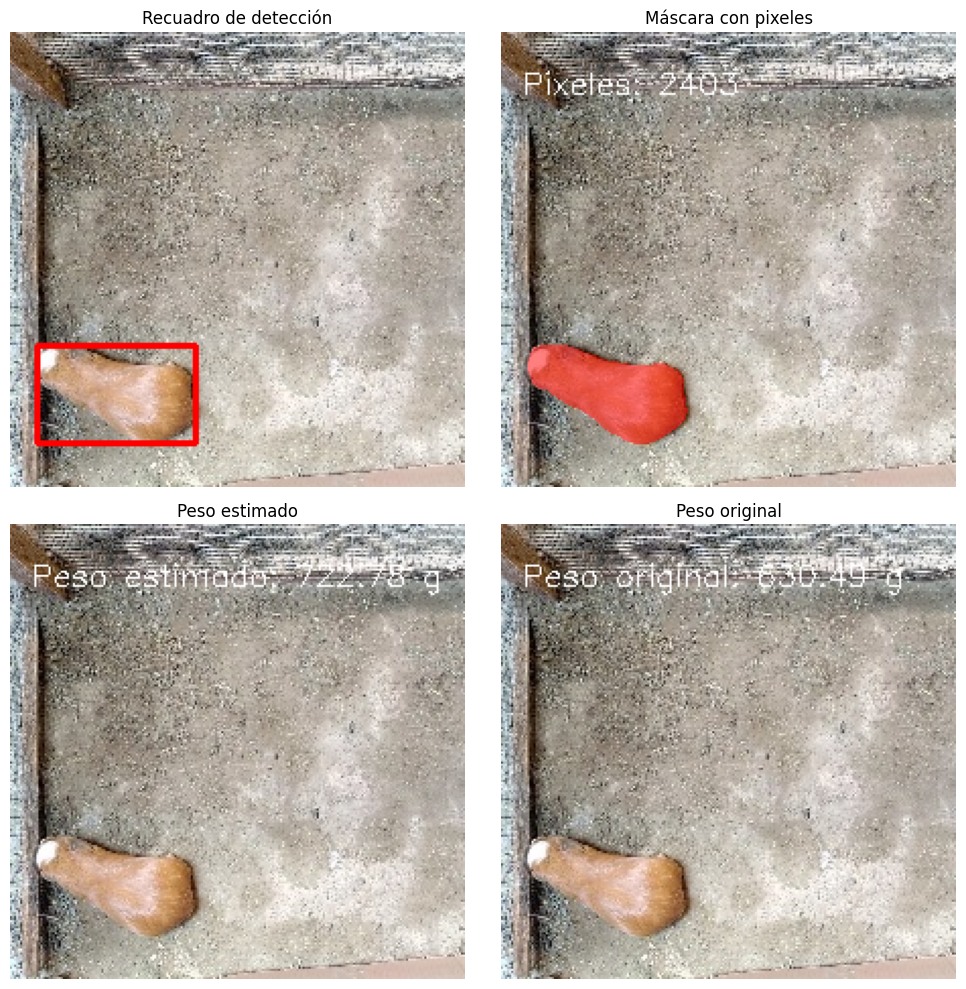

In [ ]:
import os
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

# Configuración inicial
IMAGE_NAME = "CUY_01_023_18.jpg"
path = '/content/drive/MyDrive/PDSEI/data'
path_annotations = '/content/drive/MyDrive/PDSEI/ImagenesAnotadas'
path_pesos = '/content/drive/MyDrive/PDSEI/data/Pesos.txt'

IMAGE_PATH = os.path.join(path, "images", IMAGE_NAME)
TXT_PATH = os.path.join(path_annotations, IMAGE_NAME.replace('.jpg', '.txt'))

factor_peso_pixeles = 0.30078200402462574

# Leer el peso del cuy desde el archivo Pesos.txt
def obtener_peso_original(image_name, path_pesos):
    grupo = "_".join(image_name.split("_")[:3])  # Extraer el grupo del nombre
    with open(path_pesos, 'r') as file:
        for line in file.readlines():
            if line.startswith(grupo):
                _, weight = line.strip().split(',')
                return float(weight)  # Devolver el peso en gramos
    return None  # Retornar None si no se encuentra el peso

# Leer la imagen
image_bgr = cv2.imread(IMAGE_PATH)
if image_bgr is None:
    raise FileNotFoundError(f"No se encontró la imagen en la ruta: {IMAGE_PATH}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Leer el archivo .txt
with open(TXT_PATH, 'r') as file:
    line = file.readline().strip()
    valores = line.split()
    if len(valores) >= 5:
        xc, yc, an, al = map(float, valores[1:5])
        altura, ancho = image_bgr.shape[:2]
        x1 = (xc - an / 2) * ancho
        y1 = (yc - al / 2) * altura
        x2 = (xc + an / 2) * ancho
        y2 = (yc + al / 2) * altura
        box = np.array([x1, y1, x2, y2])

# Configurar predictor y realizar predicción
mask_predictor.set_image(image_rgb)
masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

# Crear anotadores y detecciones
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]  # Máscara más grande

# Calcular número de píxeles del cuy
pixeles_cuy = np.sum(detections.mask[0])  # Máscara binaria: suma de píxeles activados

# Calcular peso estimado
peso_estimado = pixeles_cuy * factor_peso_pixeles

# Obtener el peso original del cuy
peso_original = obtener_peso_original(IMAGE_NAME, path_pesos)

# Generar las imágenes anotadas
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)

mask_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
cv2.putText(mask_image, f"Pixeles: {pixeles_cuy}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

peso_estimado_image = image_bgr.copy()
cv2.putText(peso_estimado_image, f"Peso estimado: {peso_estimado:.2f} g", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

peso_original_image = image_bgr.copy()
if peso_original is not None:
    cv2.putText(peso_original_image, f"Peso original: {peso_original:.2f} g", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
else:
    cv2.putText(peso_original_image, "Peso original no encontrado", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Mostrar las imágenes en una cuadrícula 2x2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

titles = ["Recuadro de detección", "Máscara con pixeles", "Peso estimado", "Peso original"]
images = [source_image, mask_image, peso_estimado_image, peso_original_image]

for ax, title, img in zip(axes, titles, images):
    ax.set_title(title)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis("off")

plt.tight_layout()
plt.show()


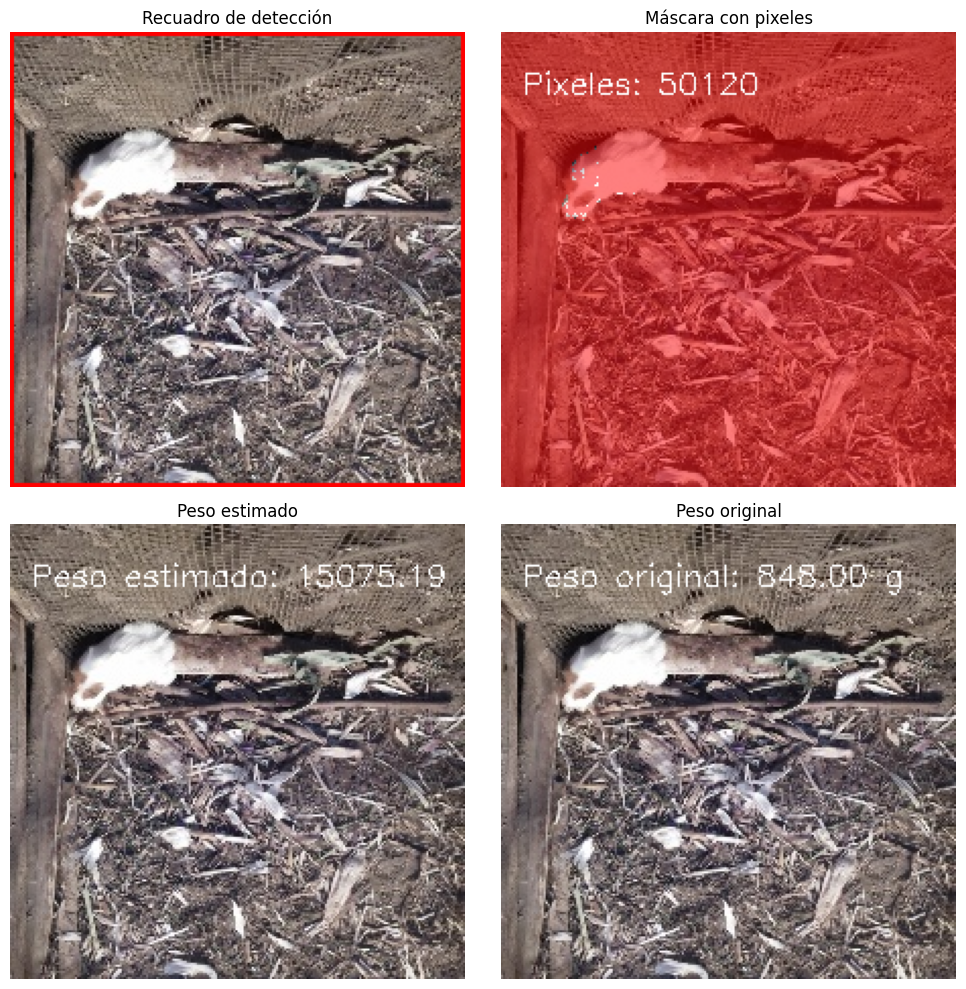

In [ ]:
import os
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

# Configuración inicial
IMAGE_NAME = "CUY_00_177_01.jpg"
path = '/content/drive/MyDrive/PDSEI/data'
path_annotations = '/content/drive/MyDrive/PDSEI/ImagenesAnotadas'
path_pesos = '/content/drive/MyDrive/PDSEI/data/Pesos.txt'

IMAGE_PATH = os.path.join(path, "images", IMAGE_NAME)
TXT_PATH = os.path.join(path_annotations, IMAGE_NAME.replace('.jpg', '.txt'))

factor_peso_pixeles = 0.30078200402462574

# Leer el peso del cuy desde el archivo Pesos.txt
def obtener_peso_original(image_name, path_pesos):
    grupo = "_".join(image_name.split("_")[:3])  # Extraer el grupo del nombre
    with open(path_pesos, 'r') as file:
        for line in file.readlines():
            if line.startswith(grupo):
                _, weight = line.strip().split(',')
                return float(weight)  # Devolver el peso en gramos
    return None  # Retornar None si no se encuentra el peso

# Leer la imagen
image_bgr = cv2.imread(IMAGE_PATH)
if image_bgr is None:
    raise FileNotFoundError(f"No se encontró la imagen en la ruta: {IMAGE_PATH}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Leer el archivo .txt
with open(TXT_PATH, 'r') as file:
    line = file.readline().strip()
    valores = line.split()
    if len(valores) >= 5:
        xc, yc, an, al = map(float, valores[1:5])
        altura, ancho = image_bgr.shape[:2]
        x1 = (xc - an / 2) * ancho
        y1 = (yc - al / 2) * altura
        x2 = (xc + an / 2) * ancho
        y2 = (yc + al / 2) * altura
        box = np.array([x1, y1, x2, y2])

# Configurar predictor y realizar predicción
mask_predictor.set_image(image_rgb)
masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

# Crear anotadores y detecciones
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]  # Máscara más grande

# Calcular número de píxeles del cuy
pixeles_cuy = np.sum(detections.mask[0])  # Máscara binaria: suma de píxeles activados

# Calcular peso estimado
peso_estimado = pixeles_cuy * factor_peso_pixeles

# Obtener el peso original del cuy
peso_original = obtener_peso_original(IMAGE_NAME, path_pesos)

# Generar las imágenes anotadas
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)

mask_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
cv2.putText(mask_image, f"Pixeles: {pixeles_cuy}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

peso_estimado_image = image_bgr.copy()
cv2.putText(peso_estimado_image, f"Peso estimado: {peso_estimado:.2f} g", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

peso_original_image = image_bgr.copy()
if peso_original is not None:
    cv2.putText(peso_original_image, f"Peso original: {peso_original:.2f} g", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
else:
    cv2.putText(peso_original_image, "Peso original no encontrado", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Mostrar las imágenes en una cuadrícula 2x2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

titles = ["Recuadro de detección", "Máscara con pixeles", "Peso estimado", "Peso original"]
images = [source_image, mask_image, peso_estimado_image, peso_original_image]

for ax, title, img in zip(axes, titles, images):
    ax.set_title(title)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis("off")

plt.tight_layout()
plt.show()
